### SP025 Integration analysis Integration TME part2

In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
#import rpy2.rinterface_lib.callbacks
import logging
#import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')

In [2]:
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


In [3]:
import os              
os.environ['PYTHONHASHSEED'] = '0'
import seaborn as sb
from gprofiler import GProfiler
import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
from rpy2.robjects import pandas2ri
import anndata2ri

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_header()

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.4 scipy==1.4.1 pandas==1.1.4 scikit-learn==0.23.2 statsmodels==0.12.1 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.2


### Import dataset Lung/BC/CRC/Ovarian CD8 + CD4

In [5]:
adata = sc.read("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Desc_T_cell.h5ad")

In [6]:
print(adata.X.shape)

(31018, 11358)


In [7]:
adata.var.index = adata.var.index.astype(str)

In [8]:
adata.var.gene_id = adata.var['gene_id'].astype(str)

In [9]:
del adata.var['gene_id']

In [11]:
adata.var['gene_id'] = adata.var.index

### Clustree

In [12]:
data_clus = adata.obs[['desc_0.4','desc_0.6','desc_0.7','desc_0.8']]

In [13]:
data_clus.columns

Index(['desc_0.4', 'desc_0.6', 'desc_0.7', 'desc_0.8'], dtype='object')

In [14]:
data_clus.columns = ['desc_r4_clusters', 'desc_r6_clusters', 'desc_r7_clusters', 'desc_r8_clusters']

In [15]:
data_clus.to_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index=True,header=True)
data_clus2 = pd.read_csv("/mnt/lugli/spuccio/SP028_Autoimmunity/h5_files/temp.csv",index_col=0,header=0)

In [16]:
# these are the defaults we want to set:
default_units = 'in' # inch, to make it more easily comparable to matpplotlib
default_res = 100 # dpi, same as default in matplotlib
default_width = 10
default_height = 9
# try monkey-patching a function in rpy2, so we effectively get these
# default settings for the width, height, and units arguments of the %R magic command

old_setup_graphics = rpy2.ipython.rmagic.RMagics.setup_graphics

def new_setup_graphics(self, args):
    if getattr(args, 'units') is not None:
        if args.units != default_units: # a different units argument was passed, do not apply defaults
            return old_setup_graphics(self, args)
    args.units = default_units
    if getattr(args, 'res') is None:
        args.res = default_res
    if getattr(args, 'width') is None:
        args.width = default_width
    if getattr(args, 'height') is None:
        args.height = default_height        
    return old_setup_graphics(self, args)

rpy2.ipython.rmagic.RMagics.setup_graphics = new_setup_graphics

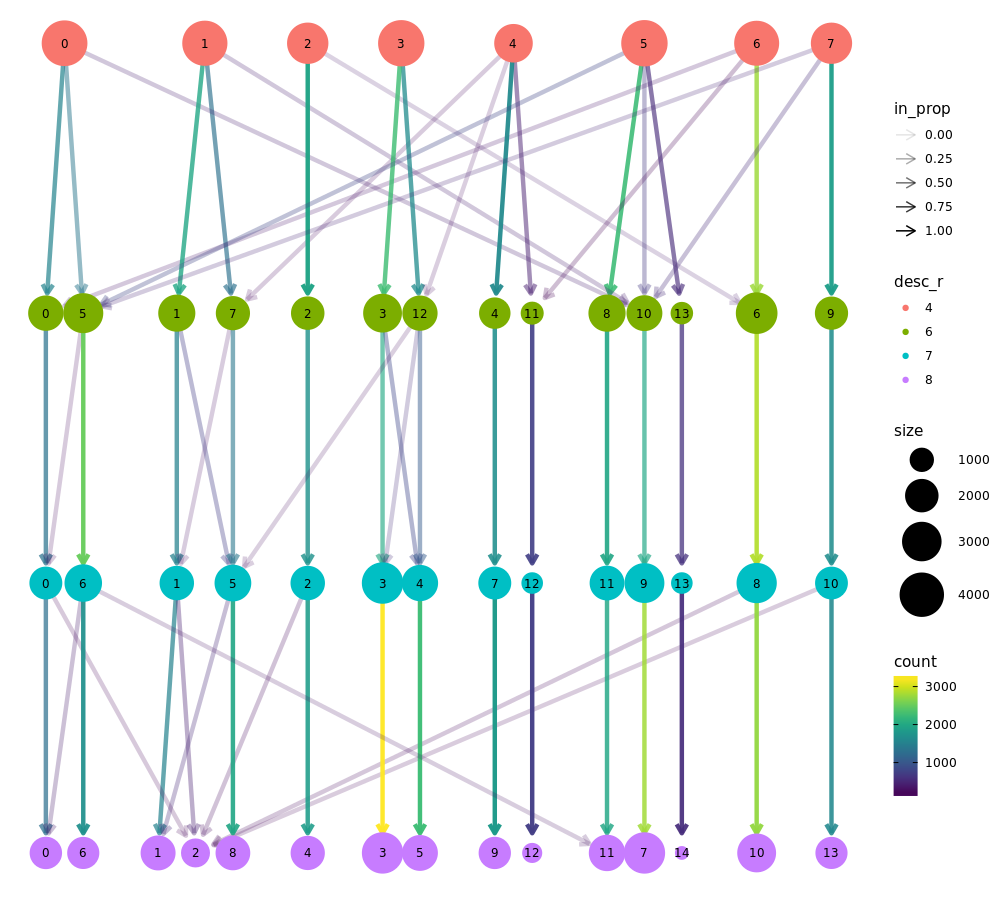

In [17]:
%%R -i data_clus2
library(clustree)

clustree(data_clus2,prefix="desc_r",suffix = "_clusters")

### UMAP of Cluster

In [18]:
def run_vis(adata):
    if 'X_emb' in adata.obsm:
        sc.pp.neighbors(adata, use_rep='X_emb')
        sc.tl.umap(adata)
    else:
        sc.pp.pca(adata, svd_solver='arpack')
        sc.pp.neighbors(adata)
        sc.tl.umap(adata)

### Analysis with Resolution 0.4 

In [20]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.4)]
run_vis(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:13)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:33)


In [21]:
adata.obs['TumorType'] = adata.obs['TumorType'].astype(str)

... storing 'TumorType' as categorical


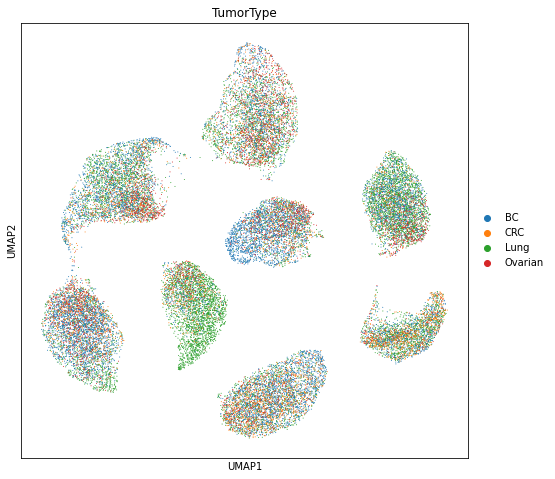

In [22]:
sc.pl.umap(adata, color='TumorType'); plt.show()

In [23]:
#adata = adata[adata.obs['CellFromTumor']  == 1,:]

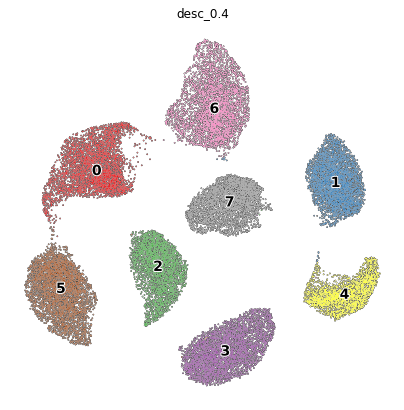

In [24]:
rcParams['figure.figsize'] = 7, 7
sc.pl.umap(adata, color='desc_0.4', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.4', palette='Set1')

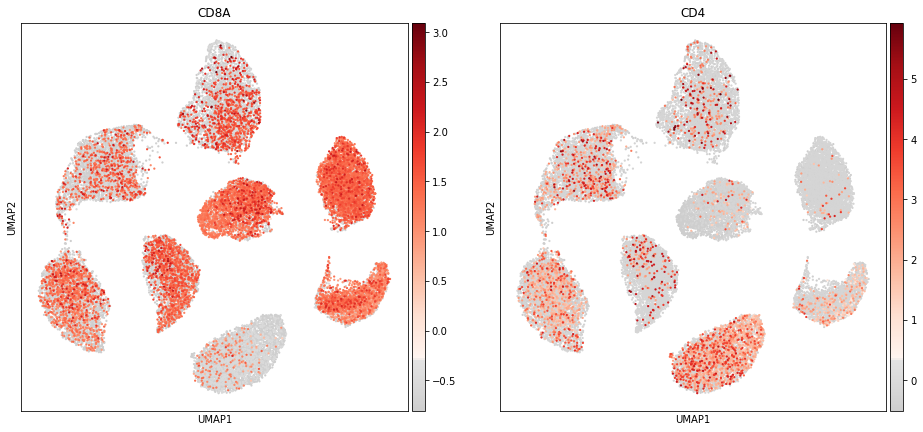

In [26]:
adata.raw = adata
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

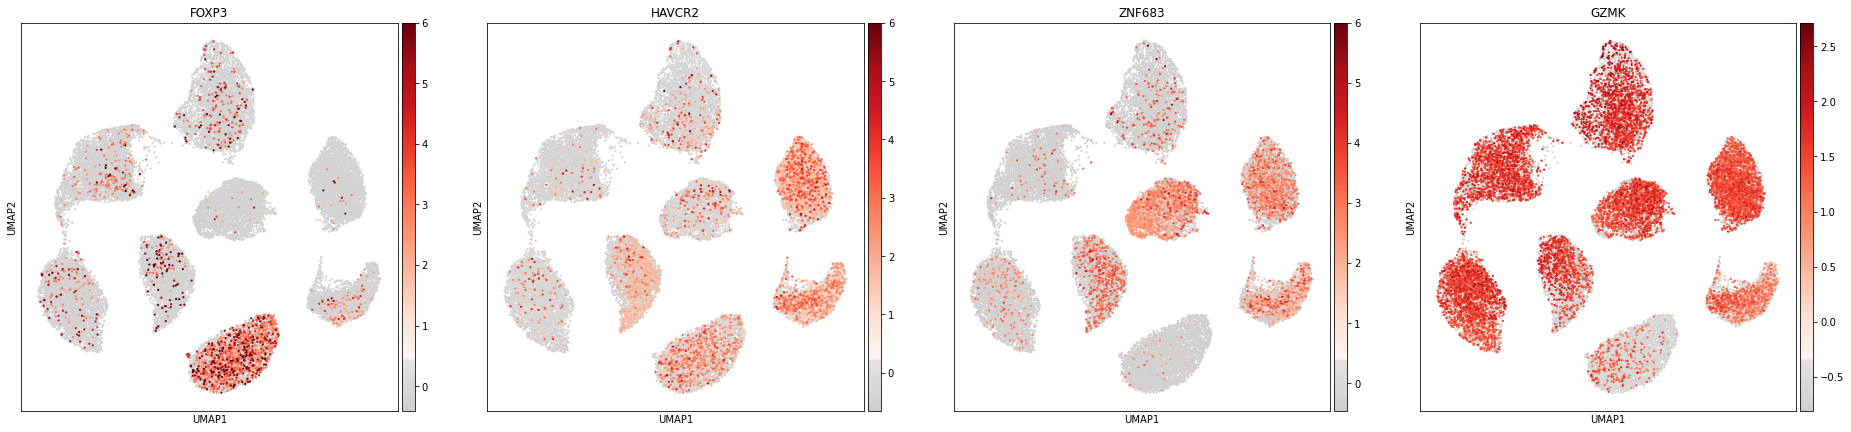

In [38]:
sc.pl.umap(adata, color=['FOXP3','HAVCR2','ZNF683','GZMK'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

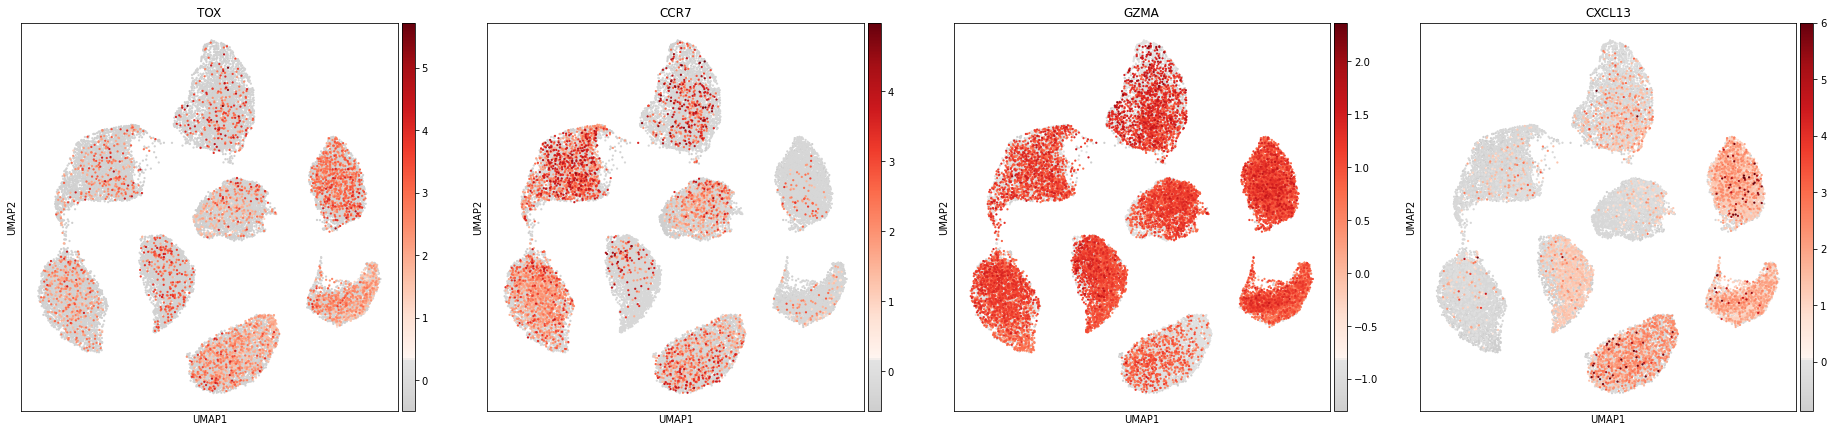

In [41]:
sc.pl.umap(adata, color=['TOX','CCR7','GZMA','CXCL13'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

In [49]:
adata.obs['PatientNumber'] = 'PTZ' + adata.obs['PatientNumber'].astype(str)

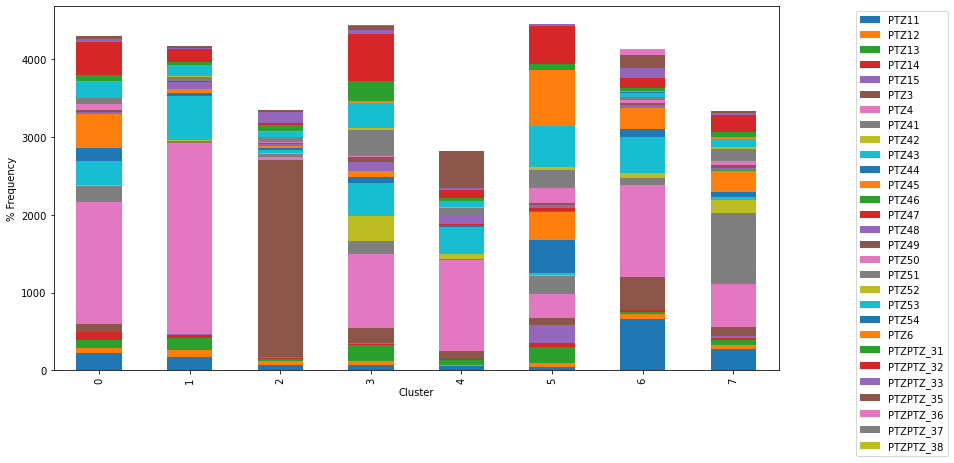

In [51]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.4")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

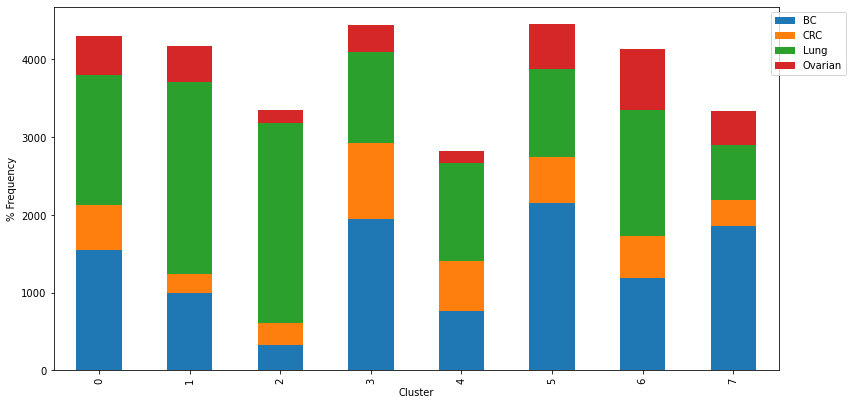

In [52]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.4")["TumorType"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### DEGS 

In [55]:
sc.tl.rank_genes_groups(adata, 'desc_0.4', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:34)


0         1         2         3         4          5         6  \
0       BTG1    CXCL13  SH3BGRL3   TNFRSF4     STMN1     EEF1A1       B2M   
1       TPT1      GZMB    TMSB4X  TNFRSF18    CXCL13       IL7R     HLA-B   
2       IL7R      NKG7    S100A6     DUSP4      LAG3    SCGB3A1    TMSB4X   
3        FAU      LAG3      MLPH      BATF      GZMB  MTRNR2L12     HLA-A   
4      TXNIP      CD8A   RTN4RL2     TIGIT   HLA-DRA    ZFP36L2    TMSB10   
5      CXCR4      CCL4    CADPS2      TYMP      TUBB     EEF1B2     HLA-C   
6       PTMA      CD8B   LGALS9C     CTLA4      CCL3      NAPSA      ACTB   
7       EIF1      GZMH    CX3CL1    CORO1B      GZMH      ZNF90      PTMA   
8        B2M      GZMA      TBX3     DNPH1      IFNG     AKR1C1      FTH1   
9      UBA52      CCL5      COBL      ICA1       DEK    HNRNPA1      BTG1   
10      JUNB      PTMS      FGF9    SPOCK2    PLSCR1        LTB       FAU   
11   TSC22D3  APOBEC3G  EPB41L4A      UCP2      PTMS      DUSP1       FTL   
12    TMSB10  HLA-DRB1    GALNT8       PKM       DUT     NBEAL1      EIF1   
13       FOS      LY6E    TTC30A  TNFRSF1B     YWHAH     TPSAB1     HLA-E   
14     SARAF      CTSW     NPHP1       SLA      TMPO      INHBB      TPT1   
15     HLA-E  HLA-DPA1      PRCD       CD4     HMGB2      IFI30     CXCR4   
16     EEF1D  HLA-DQA1     THAP9      RGS1       MX1    TACSTD2      SRGN   
17    TMSB4X    HAVCR2    ROPN1L      IFI6  HLA-DRB5       RHOV     PTPRC   
18      NACA      RBPJ     SNX22     CCNJL  C12orf75      CXADR       UBC   
19      FTH1     ISG15     KCNH3    ZNF222      GNLY       SPP1   TSC22D3   
20   ZFP36L2      CCL3   NUP62CL      IDO1      TPM4      SFTA2      DDX5   
21    PABPC1      CST7  C11orf95      OAS1     FASLG    SMPDL3A      JUNB   
22     PFDN5    IFITM2     ADAP2      AGRN     FABP5    COL23A1     GAPDH   
23     HLA-C    CLECL1      NT5M       ARC    TUBA1B       PPIA      IL32   
24      CD69      IFNG      CES1      SNCG      OASL      SCRG1     UBA52   
25     HLA-B     DRAP1    IQSEC3      PIFO     HMGN2    FAM184B  HSP90AA1   
26     HLA-A     PSMB9     PRRT1      RERG    HAVCR2      HMGN2   ANKRD50   
27      EEF2      CD74     TRPV1    CMKLR1      IFI6      TXNIP      CA13   
28       LTB     LRRN3      ESR1     PRAM1     SMC1A      PTGS2      ERMN   
29     TOMM7   ALOX5AP      TLR6   ZSCAN31     ANXA5     SCNN1A     ENPP2   
30      DDX5      GNLY    KCNAB3      ICOS     DNMT1        GML     AGBL3   
31    EEF1B2     ADAP1       SCX   TPD52L1    RANBP1      MPZL2  KIAA1522   
32     PTPRC    FCGR3B      DOK3     PTGR1     RSAD2        NMU      FGD6   
33       FTL       STS   ZDHHC23     APLP1      MCM7       FCN1   TNFSF11   
34     ITM2B     LRRK2     BCL7A    ZNF503     IFI35     HEXIM1      AFF3   
35   ARHGDIB    TBC1D9    NT5DC3   RAPGEF3   HLA-DMA      TREM1    DZANK1   
36    GIMAP7  C17orf97    CCDC17     FOXJ1   EIF2AK2      CCL18  C19orf73   
37    MYL12A     PTPRB    ZNF618   PPP1R9A      SMC4       OLR1     CDAN1   
38     DUSP1      NID1    SH3D21       LTB     CENPU     GIMAP7       MPZ   
39      CD52    PLXNA2      DNM3     TUSC3  HLA-DRB1       OSMR      SYNM   
40      CCR7     ACKR3   PRKAR2B    DCBLD2      RHEB      ITGB6   CCDC189   
41      ACTB     ABHD1   L3MBTL4      RBP1     CMPK2     DNAJB4   CCDC171   
42      BTF3     MMRN2    RASIP1    SH2D1B    RAB27A       SLPI     PRRG2   
43     FXYD5    CFAP53      AMOT   RARRES1      LAP3        SYP      PPT2   
44      LDHB    RASAL2   FAM234B     NR3C1  TMEM106C       NPM1     GCNT2   
45      SELL     MEX3D    ZNF516      MNDA     CKS1B      RAB38    ATP2A1   
46      KLF6   RANBP17      REM2      PIM2      PCNA       CD48     ABCA3   
47     EIF3E     MCTP1    ZNF629      BCAM     ISG15      TPSB2     ADCK1   
48     COX7C    PRSS36    IL17RC      RHOC     LMNB1    ANGPTL4   SPATA6L   
49  LEPROTL1      NPM2   EFCAB13     STAT1   SLC25A5      NACA2   TMEM182   

           7  
0       CTSW  
1      KLRD1  
2       NKG7  
3       HOPX  
4       

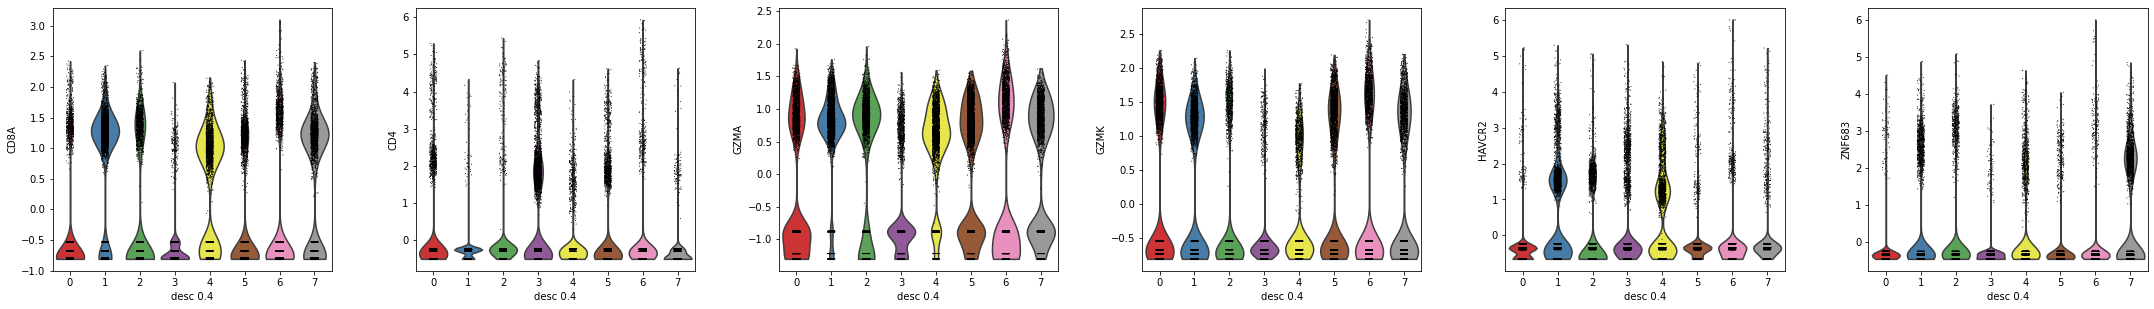

In [67]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata, ['CD8A', 'CD4','GZMA','GZMK'], groupby='desc_0.4')

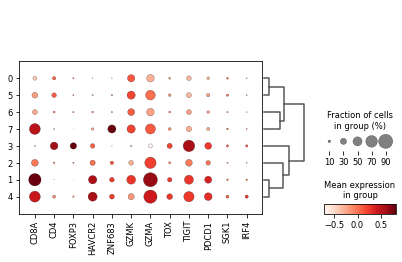

In [76]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata, ['CD8A','CD4','FOXP3','HAVCR2','ZNF683','GZMK','GZMA','TOX','TIGIT','PDCD1','SGK1','IRF4'], 'desc_0.4', dendrogram=True)

### Export Resolution 0.4

In [78]:
result = adata.uns['rank_genes_groups']

In [79]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res04_DEGS.csv",header=True,index=False)

In [80]:
adata.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res04.h5ad")

### Analysis with Resolution 0.6

In [82]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.6)]
run_vis(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


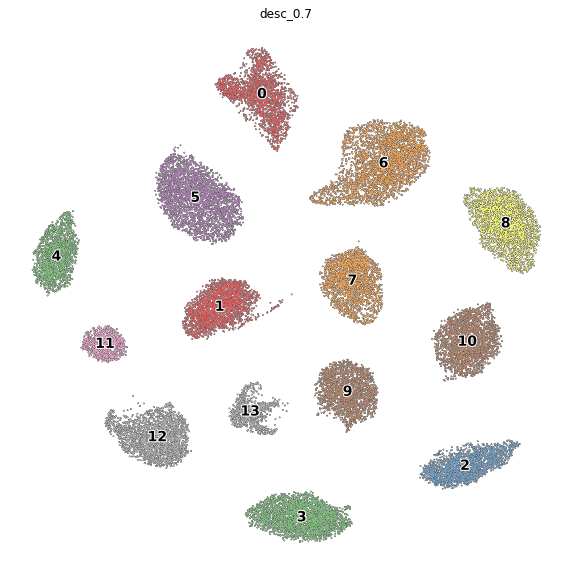

In [87]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata, color='desc_0.6', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.6', palette='Set1')

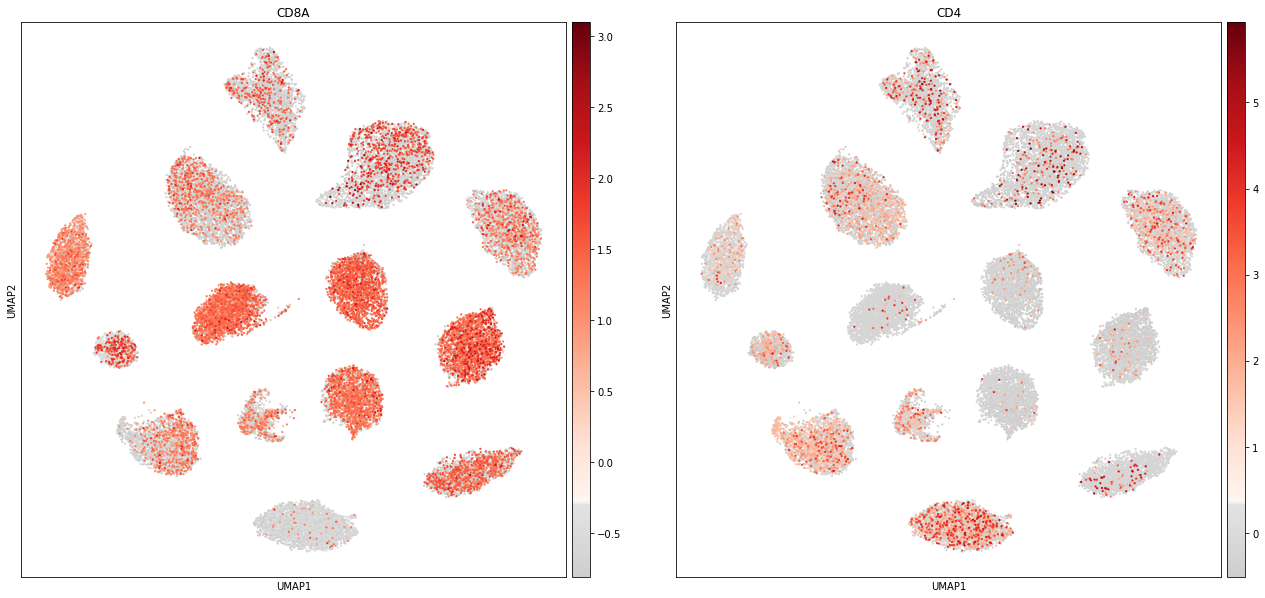

In [88]:
adata.raw = adata
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

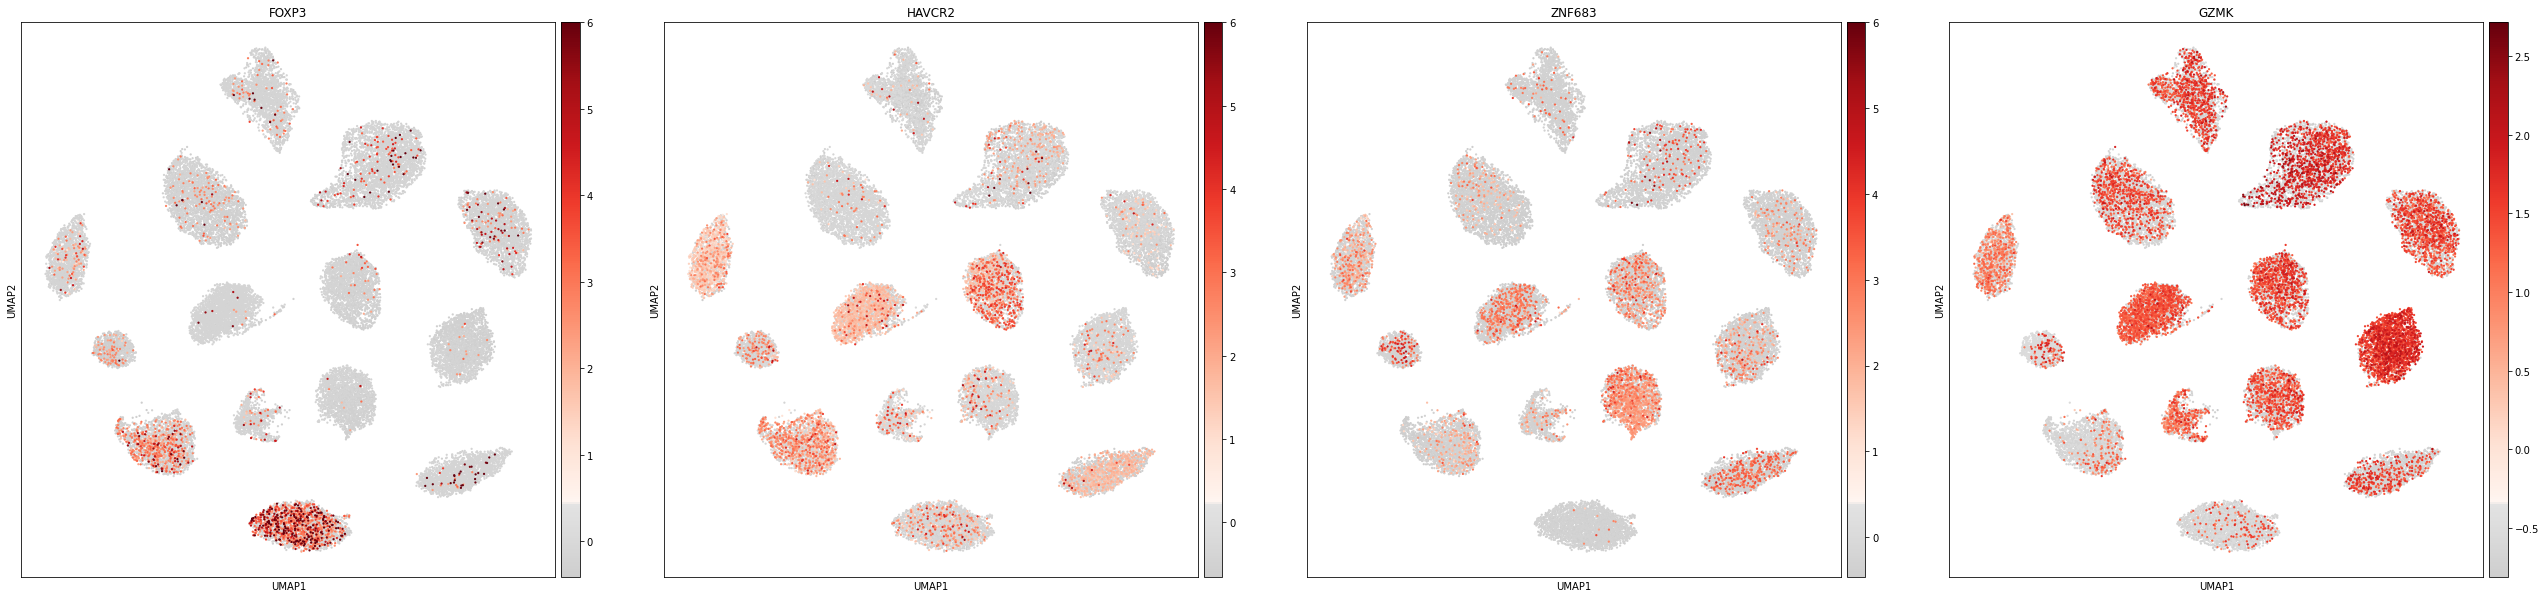

In [89]:
sc.pl.umap(adata, color=['FOXP3','HAVCR2','ZNF683','GZMK'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

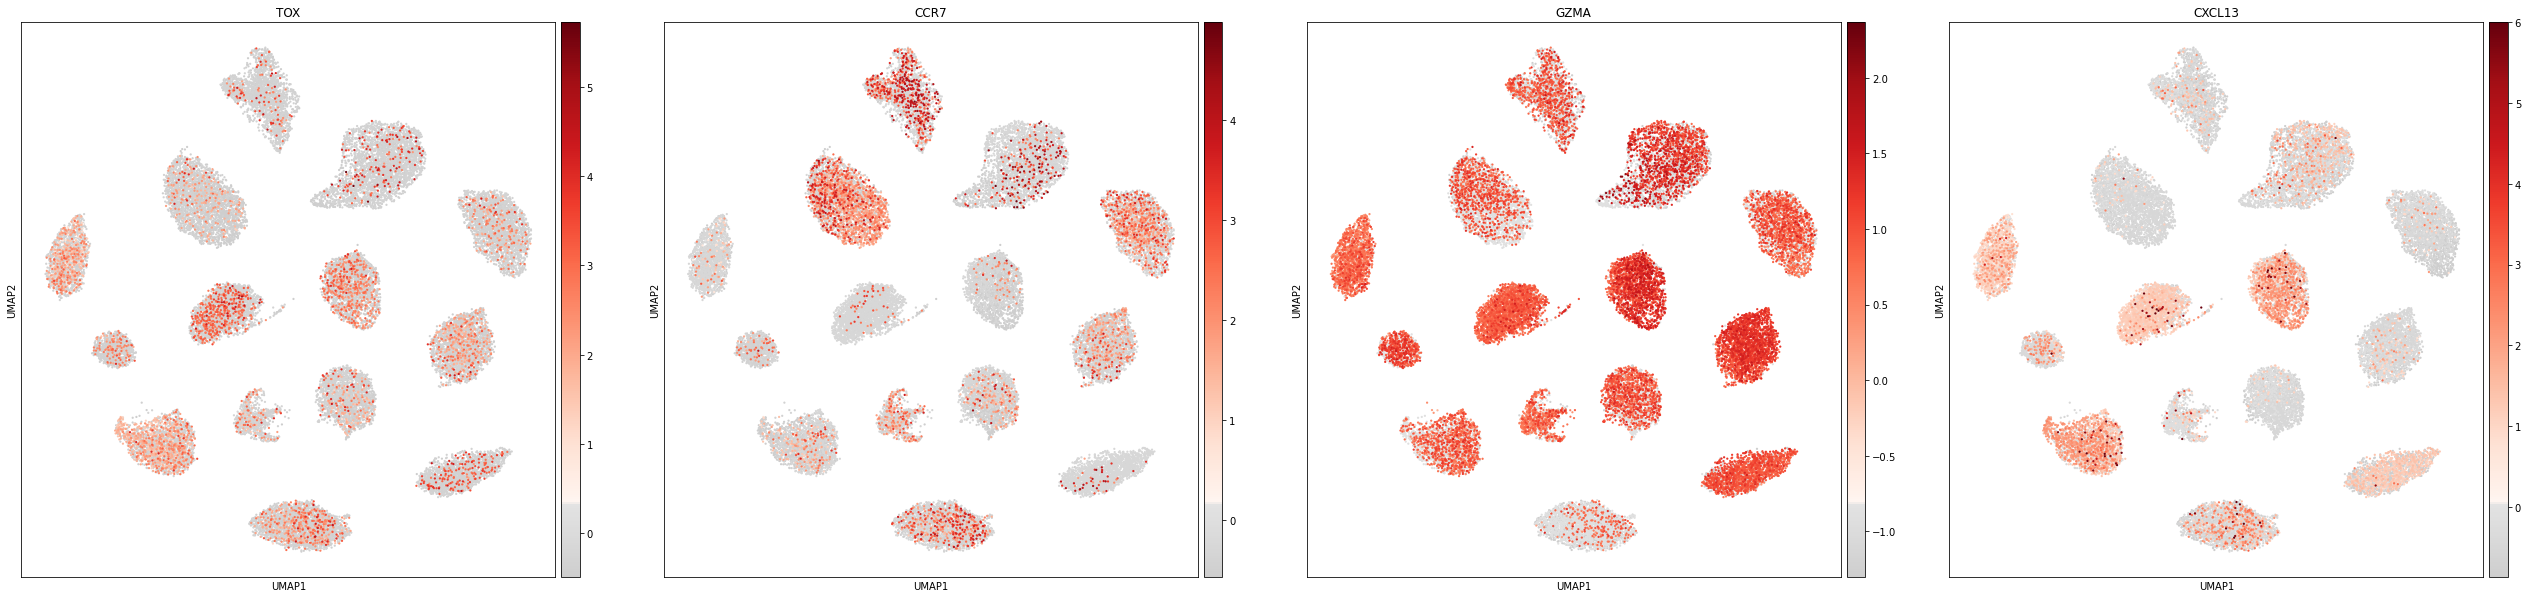

In [90]:
sc.pl.umap(adata, color=['TOX','CCR7','GZMA','CXCL13'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

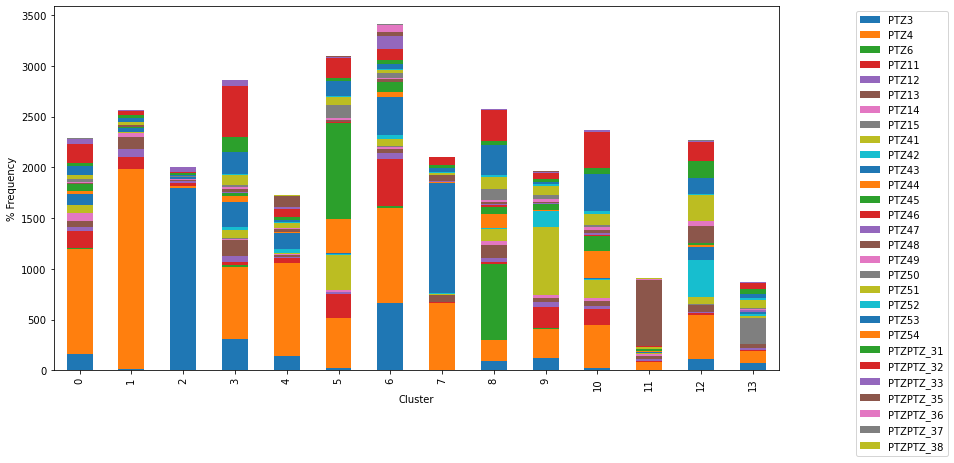

In [93]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

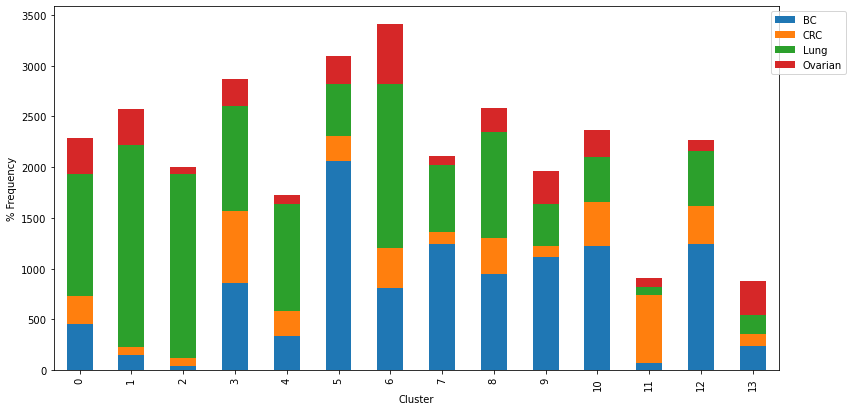

In [94]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.6")["TumorType"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### DEGS resolution 0.6

In [95]:
sc.tl.rank_genes_groups(adata, 'desc_0.6', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:44)


0          1          2         3         4         5         6  \
0      BTG1       SIX5     CADPS2   TNFRSF4     STMN1      IL7R       B2M   
1      IL7R      CNIH2   C16orf46       LTB      TUBB       FOS    TMSB4X   
2       B2M     ZNF469       FGF9      BATF     CKS1B     CXCR4     HLA-B   
3       FAU     KLHL13       NEFM     TIGIT       DUT     CXADR     HLA-A   
4      TPT1     KCNJ14     GALNT8      PIM2    TUBA1B     INHBB      ACTB   
5      PTMA       DYSF     MANEAL  TNFRSF18      MCM7      RHOV    TMSB10   
6     TXNIP   C16orf46       COBL     CTLA4      TMPO   SMPDL3A     HLA-C   
7    TMSB4X     POLR3G     KLHL13    CORO1B     DTYMK    ZBTB16      PTMA   
8      EIF1     MANEAL    CACNA1I      CD27      TYMS     PTGS2       FAU   
9    TMSB10    CCDC154    RTN4RL2     FOXP3     YWHAH   COL23A1      FTH1   
10     JUNB      PTPRO      CNIH2    SPOCK2  TMEM106C       GML       FTL   
11    HLA-E      TGFB3     KCNJ14      ICOS     SMC1A      OLR1      TPT1   
12    UBA52      SPDYA       DYSF      IL32     NUDT1      FCN1      BTG1   
13  TSC22D3     ZFP69B       TLR6    CARD16     DNMT1     SCRG1      EIF1   
14    EEF1D      APBB2       PRCD    TBC1D4      PCNA     TREM1     CXCR4   
15    HLA-B  TNFRSF11A     CX3CL1      SAT1    DNAJC9     ITGB6     GAPDH   
16    SARAF      NLGN2    LGALS9C  TNFRSF1B     LMNB1       NMU     HLA-E   
17    HLA-C      ASAH2       PIGZ    ARID5B       DEK     MPZL2      SRGN   
18     FTH1      MMRN1      APBB2      UCP2     MKI67     IFI30      IL32   
19      FOS    TSPAN33      HPGDS      RGS1  C12orf75      OSMR     UBA52   
20    CXCR4       PIGZ     IQSEC3      SELL    RANBP1    SCNN1A      CA13   
21    HLA-A      MEX3B      PTPRO     BIRC3      CDT1   FAM184B     PRRG2   
22     NACA   GLIPR1L2        ABO    PBXIP1     HMGB2     NAPSA       UBC   
23      FTL      LRRC3       SIX5     IL2RA    NUSAP1     APOL4   ANKRD50   
24     ACTB        ABO     ZNF185     DNPH1   CARHSP1      CD1C  KIAA1522   
25    PFDN5     ZNF185       NT5M      ICA1      RPA3  ADAMTSL4     AGBL3   
26     DDX5    TBC1D8B    CCDC154      UGP2      EZH2     CCL21     ENPP2   
27   PABPC1      PROS1    TSPAN33       CD4     ATAD2      HEY1    ATP2A1   
28  ARHGDIB      HPGDS      PROS1    EPSTI1     UBE2S      EDN1   CCDC189   
29    ITM2B    RASL11A      LRRC3    ARPC1B      USP1     FGF22      FGD6   
30     CD69      WDR78      NPHP1     CIRBP     CENPK     RAB38   TNFSF11   
31     KLF6    ARHGEF4      MMRN1     CALM3      CBX5      PTK6      AFF3   
32    PTPRC       TLN2       MLPH     FXYD5      DHFR     HUS1B    LRRC56   
33    TOMM7     FAM89A   EPB41L4A     RTKN2     PSMC3       CGN      ERMN   
34    FXYD5       NEFM      RIBC2      SOD1      LSM4   TMEM125     ABCA3   
35     CD52      MUC20    TBC1D8B    PMAIP1      LSM5     TLCD1      PPT2   
36   MYL12A     SCARF2     PEX11G      OAZ1   ZDHHC12   ANGPTL4  C19orf73   
37     CCR7      SENP8   C11orf95     YWHAB     KIF22    CYB5RL   SPATA6L   
38     EEF2    CYSLTR2       TLE2      ETV7      NASP     EFNA3    DZANK1   
39   EEF1B2     MAMLD1       DOK3      TYMP     CENPN      SDSL     ERMAP   
40     CFL1       ATL1      WDR78     ISG20  RNASEH2C   ALDH3B1      BBS1   
41      LTB     ANKRD6     SH3D21    S100A4     PRDX3    KLHL23   CCDC171   
42     SELL    CACNA1I     SCARF2     DUSP4      SLBP    SEZ6L2     EPM2A   
43   DBNDD1      DMXL2      TRPV1       SLA   CCDC167     SCIMP     CDAN1   
44     PPT2      LAMA2      NLGN2     HERC5    CXCL13     CH25H     CTPS2   
45  ZFP36L2   C19orf38  TNFRSF11A    DLGAP1     SIVA1     KCNK1    DBNDD1   
46  ANKRD50    PLEKHH2     ZNF469      CCNI      LSM3    ERRFI1      FRS3   
47  FAM216A    PLEKHG5       TBX3      FCMR     PHF19   TACSTD2     FITM2   
48  TNFSF11      CARD9     KISS1R   SH3BGRL    DDX39A  SLC25A29     SMAD1   
49  CCDC171      AQP11      PPM1L     IKZF2      SMC4    PRR15L      SYNM   

           7          8             9        10        11        12       13  
0  

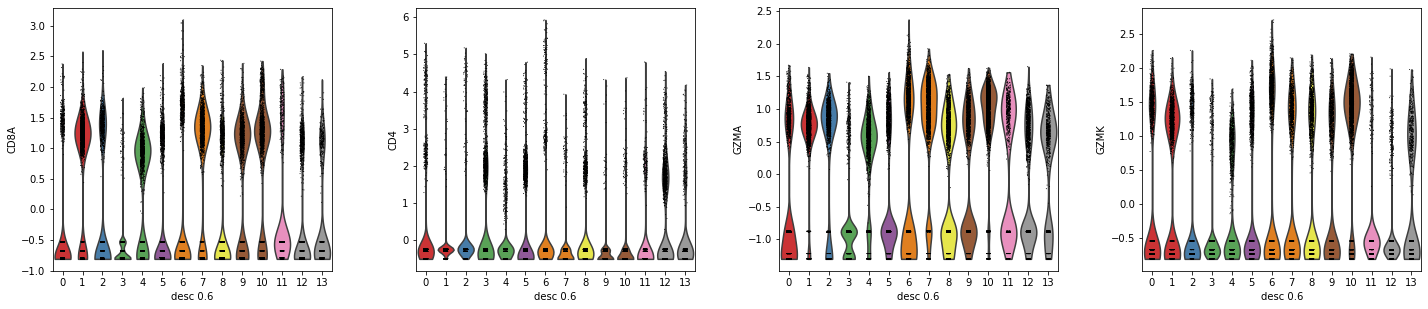

In [96]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata, ['CD8A', 'CD4','GZMA','GZMK'], groupby='desc_0.6')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns["dendrogram_['desc_0.6']"]`


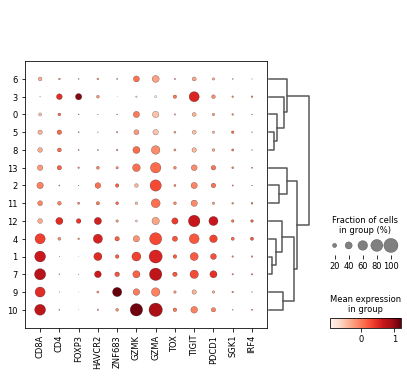

In [97]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata, ['CD8A','CD4','FOXP3','HAVCR2','ZNF683','GZMK','GZMA','TOX','TIGIT','PDCD1','SGK1','IRF4'], 'desc_0.6', dendrogram=True)

### Export Resolution 0.6

In [98]:
result = adata.uns['rank_genes_groups']

In [99]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res06_DEGS.csv",header=True,index=False)

In [100]:
adata.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res06.h5ad")

### Analysis with Resolution 0.8

In [102]:
adata.obsm['X_emb'] = adata.obsm['X_Embeded_z'+str(0.8)]
run_vis(adata)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:34)


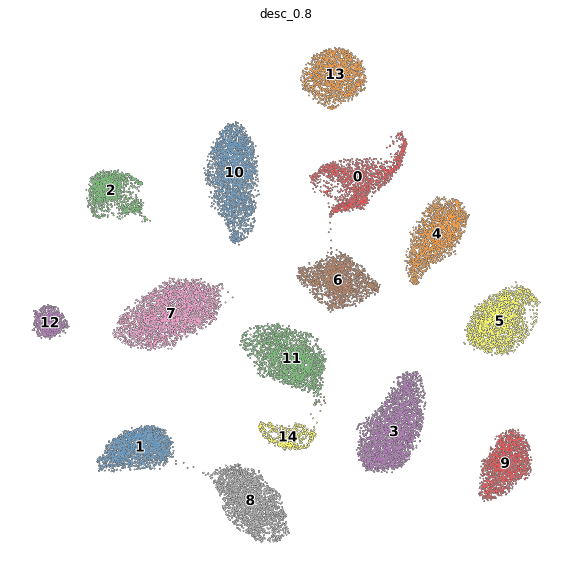

In [107]:
rcParams['figure.figsize'] = 10, 10
sc.pl.umap(adata, color='desc_0.8', add_outline=True,legend_loc='on data', 
           legend_fontsize=14, legend_fontoutline=2,frameon=False,
           title='desc_0.8', palette=sb.color_palette("Set1",20))

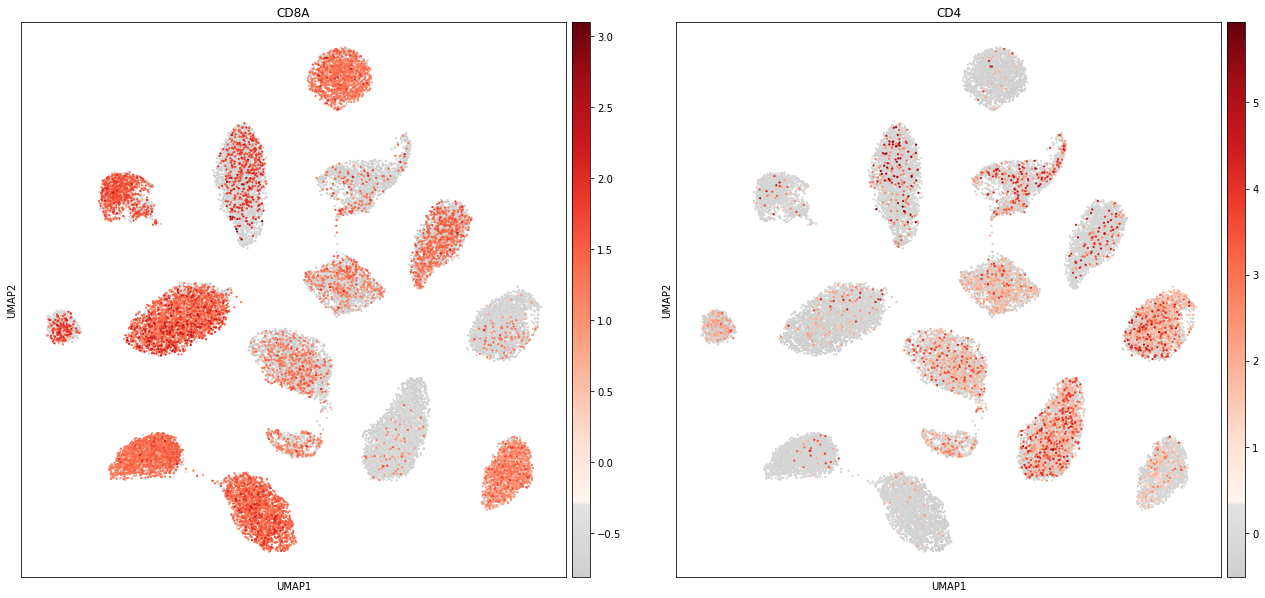

In [108]:
adata.raw = adata
colors2 = plt.cm.Reds(np.linspace(0, 1, 128))
colors3 = plt.cm.Greys_r(np.linspace(0.7,0.8,20))
colorsComb = np.vstack([colors3, colors2])
mymap = colors.LinearSegmentedColormap.from_list('my_colormap', colorsComb)
sc.pl.umap(adata, color=['CD8A','CD4'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

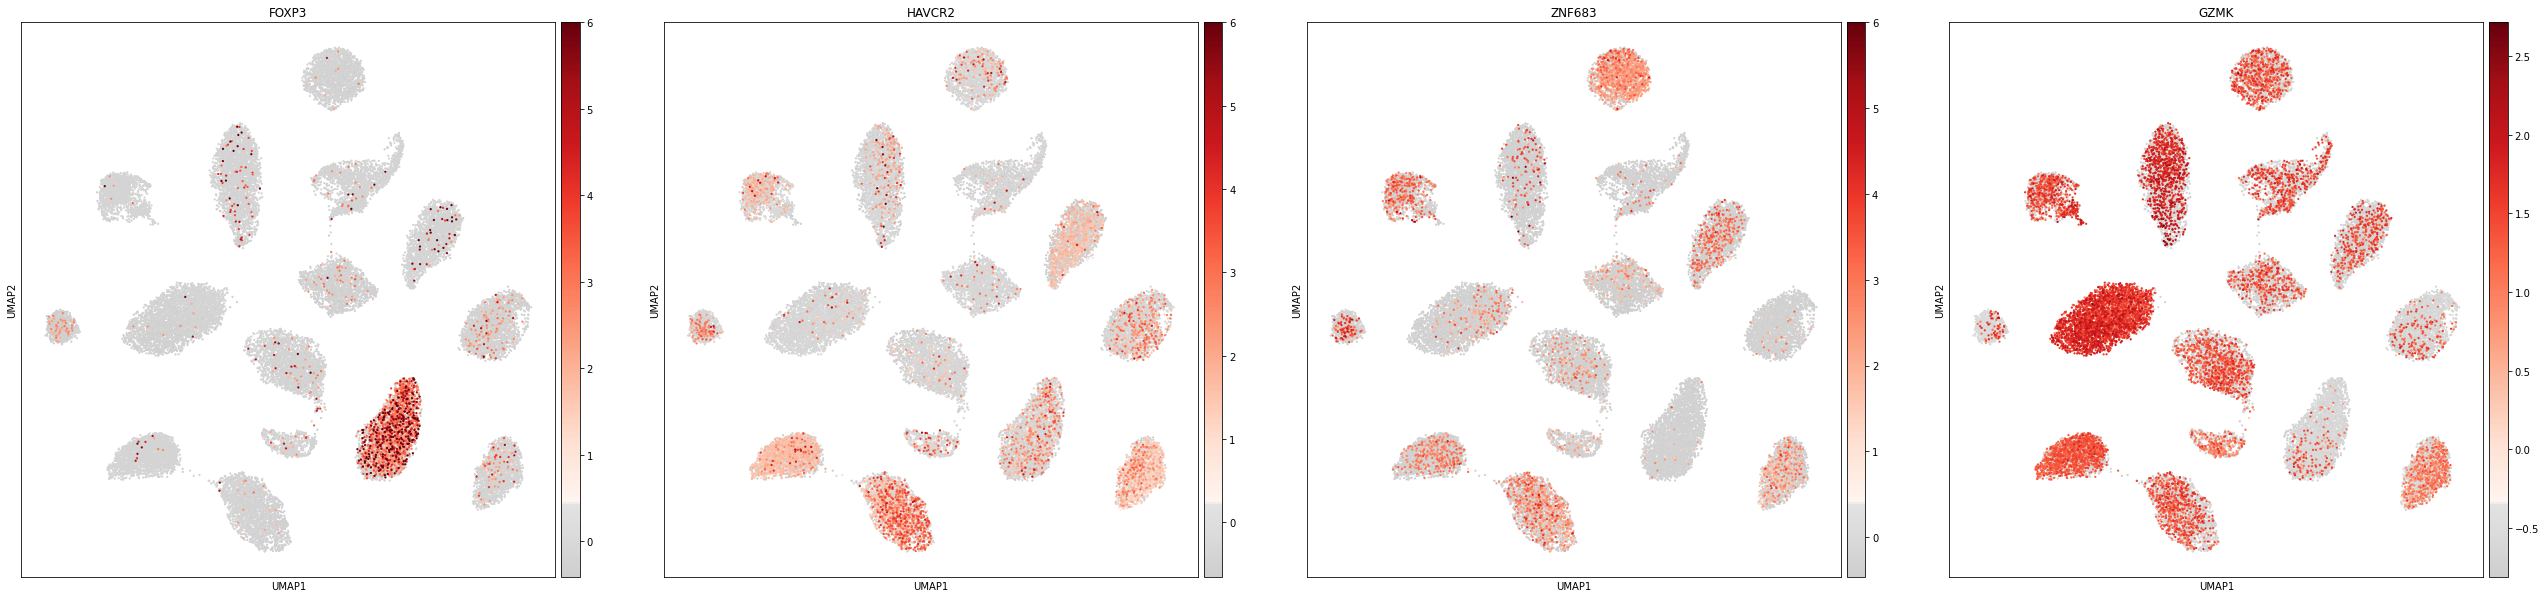

In [109]:
sc.pl.umap(adata, color=['FOXP3','HAVCR2','ZNF683','GZMK'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

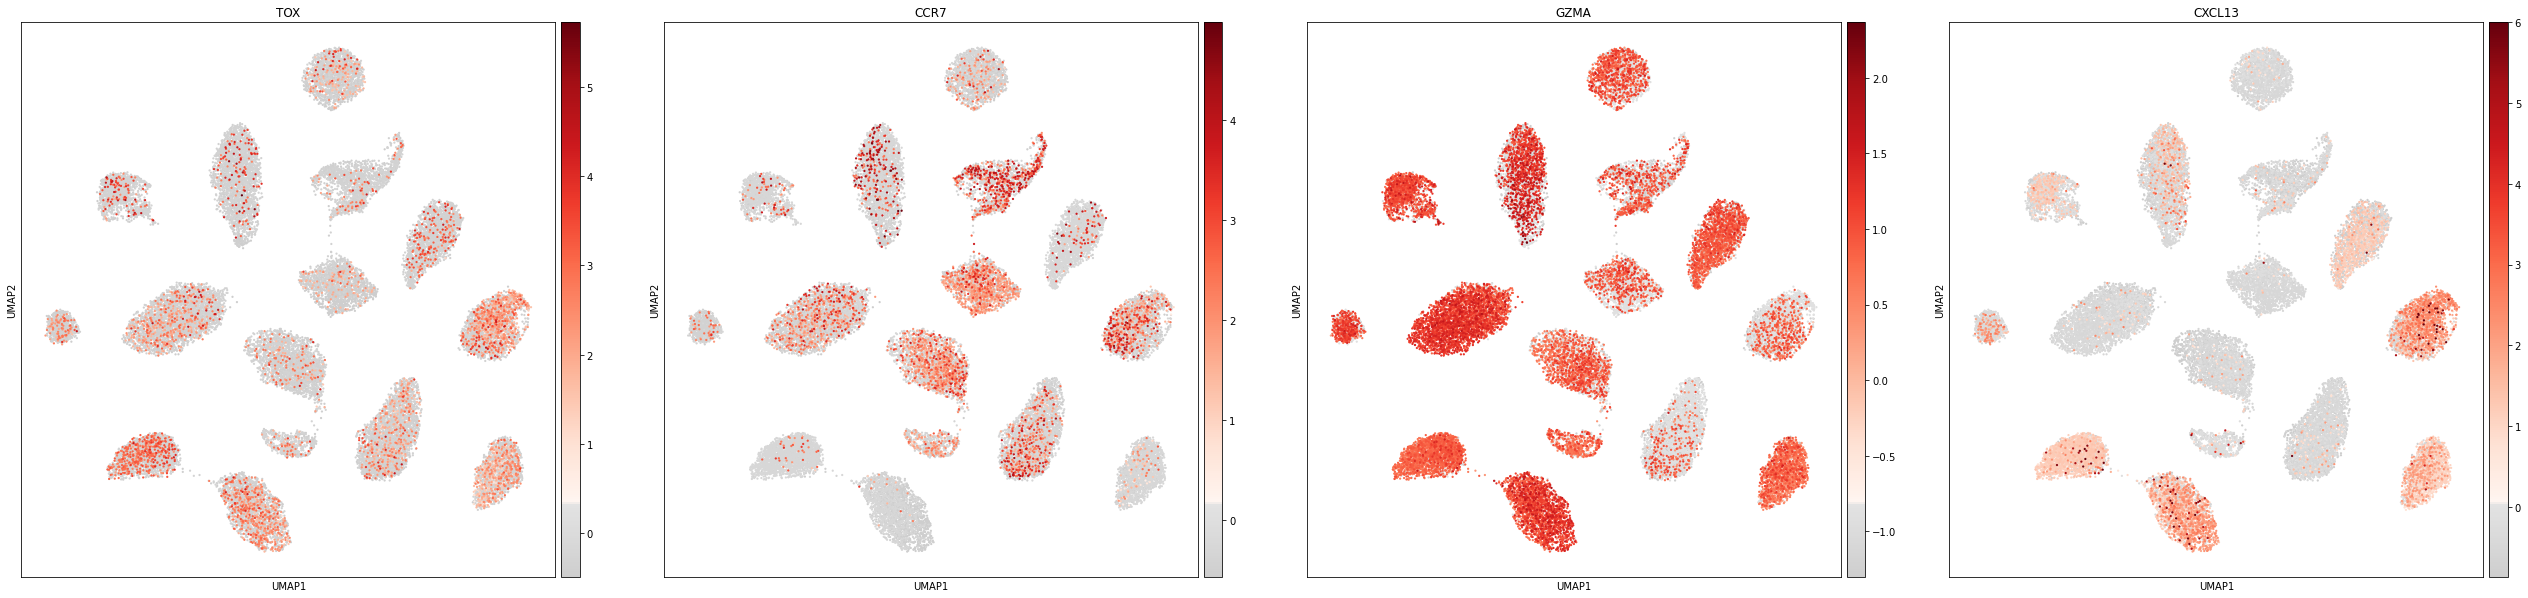

In [110]:
sc.pl.umap(adata, color=['TOX','CCR7','GZMA','CXCL13'],color_map=mymap,legend_loc='on data',s=20,use_raw=True )

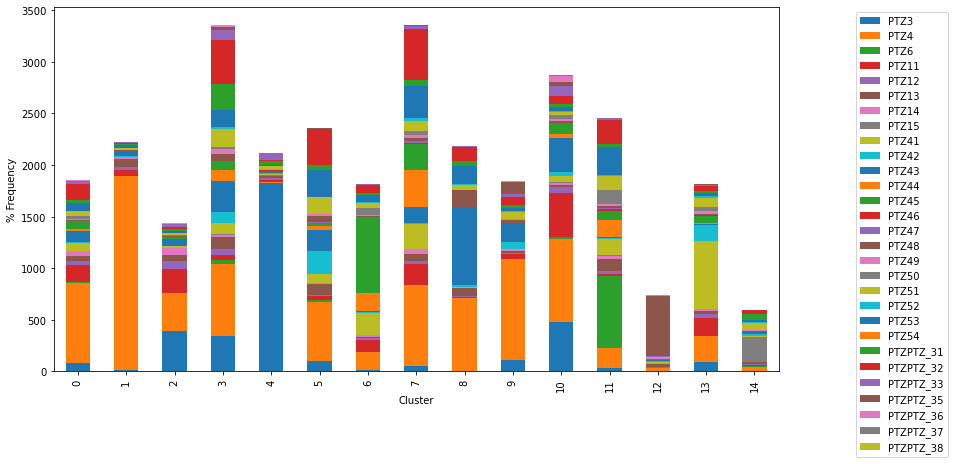

In [111]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.8")["PatientNumber"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

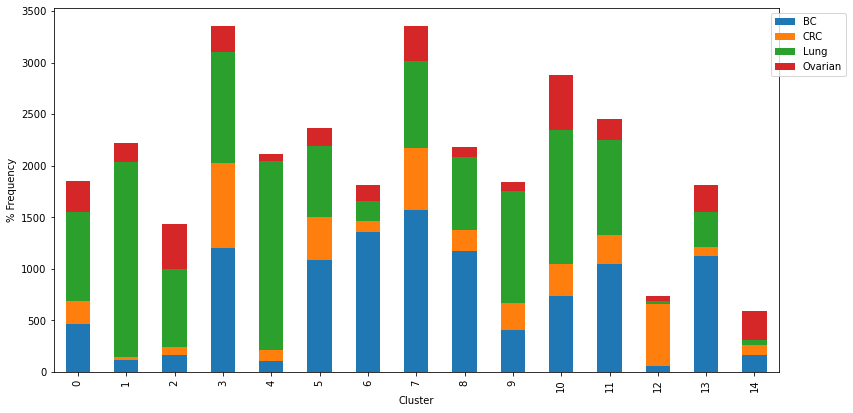

In [112]:
fig, (ax1) = plt.subplots(1,1, figsize=(33/2.54, 17/2.54))
ax1 = adata.obs.groupby("desc_0.8")["TumorType"].value_counts(normalize=False).unstack().plot.bar(stacked=True,legend=False,ax=ax1)
ax1.set_xlabel("Cluster")
ax1.set_ylabel("% Frequency")
ax1.grid(False)
ax1.legend(bbox_to_anchor=(1.1, 1.0))

### DEGS resolution 0.8

In [113]:
sc.tl.rank_genes_groups(adata, 'desc_0.8', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(50)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:46)


0           1         2         3         4         5         6  \
0       IL7R      CXCL13    TMSB4X       LTB      MLPH    CXCL13     CXADR   
1       TPT1      FCGR3B      CCL5     FOXP3      COBL     NR3C1     INHBB   
2       BTG1       LRRK2   ANKRD50   TNFRSF4    CX3CL1     FKBP5      RHOV   
3      TXNIP     RANBP17      FGD6      BATF    CADPS2   TNFRSF4   SMPDL3A   
4        FAU      PLXNA2    ATP2A1      PIM2      TBX3      SRGN     PTGS2   
5      SARAF     HSD17B6      CA13     IL2RA     BCL7A  TNFRSF18     IFI30   
6       JUNB      CFAP53      PPT2     CTLA4   RTN4RL2      RBPJ   COL23A1   
7       PTMA       MMRN2     EPM2A  TNFRSF18   LGALS9C       SLA     SCRG1   
8        FOS      TBC1D9     ENPP2      IL32     NPHP1     PDCD1      OLR1   
9    TSC22D3       PTPRB   SDR42E1  TNFRSF1B   NUP62CL     ITM2A       GML   
10     UBA52     EPB41L1      BBS1      SAT1      ESR1      ICA1      FCN1   
11       B2M    SLC22A15  KIAA1522     TIGIT    GALNT8     DUSP4     TREM1   
12      EIF1    C17orf97     PRRG2      UGP2    SH3D21     KLRB1     ITGB6   
13     HLA-E       HOXA7   TNFSF11    CARD16      FGF9    CORO1B       NMU   
14    TMSB10       KITLG   CCDC189      CD27  C11orf95     TIGIT      OSMR   
15     EEF1D       ACKR3   SPATA6L    TBC1D4      CLMN       CD4     MPZL2   
16    TMSB4X      PRSS36     SYNE4    S100A4      DOK3       PKM    SCNN1A   
17      FTH1      SIRPB1      ERMN     RTKN2    IQSEC3    ZBTB16     NAPSA   
18    PABPC1       AJUBA    MTMR11    CORO1B      PRCD    SPOCK2      CD1C   
19     CXCR4      RASAL2     ABCA3      ICOS     TRPV1   PIK3IP1     APOL4   
20       LTB       RAB23     TMTC2    ARID5B   ZDHHC23      BTLA  ADAMTSL4   
21     PFDN5      ARRDC4     AGBL3     DNPH1      NT5M    NFKBIA      PTK6   
22      NACA         STS     PDZD2      RGS1      IRF6    RNF19A      HEY1   
23   ZFP36L2       ULBP2    NHLRC4      TYMP    IL17RC      CD82     FGF22   
24     FXYD5       ABHD1      GAB2    PMAIP1     KCNH3      RGS1   ALDH3B1   
25      CD69        IL33    LRRC56     BIRC3     PRRT1     LEAP2   TMEM125   
26    EEF1B2        DSC2  C19orf73    PBXIP1    ZNF629      ISCU       CGN   
27     HLA-B       BANK1    DZANK1      SELL  EPB41L4A     MEIS1      EDN1   
28     HLA-C         PSD     ZGLP1    SPOCK2      TLR6     PTTG2     HUS1B   
29      DDX5        NID1      ZNF2      GBP2       SCX  ATP6AP1L      SDSL   
30      EEF2       DOCK1     RNF32     DUSP4     THAP9      IDO1    SEZ6L2   
31     ITM2B  AC240274.1    DBNDD1      UCP2    CCDC17  MARVELD3     EFNA3   
32     TOMM7       STAC3     DYRK3      CTSC    KCNAB3     TNNC1     CCL21   
33      CCR7       MEX3D     MAP10      GBP5    TTC30A     EFNA5     TLCD1   
34       FTL      SECTM1      EGFR      FCMR      REM2    ZNF205    KLHL23   
35      CD52       HOXA9      AFF3   TPD52L1    ROPN1L    CELSR1     SCIMP   
36    CD40LG        HSF4    LANCL3      PIFO   L3MBTL4    KCNMA1     RAB38   
37    MYL12A         SHF      TFR2       ARC   KANSL1L     RAB17  SLC25A29   
38     ANXA1       BTNL9      FRS3     PRAM1   PRKAR2B     TREM2    CYB5RL   
39      KLF6        GGT5      TLR1    CMKLR1     ADAP2      LNX1     KCNK1   
40     DUSP1       BCAR3    FNBP1L     FOXJ1    LMNTD2  CATSPER1      TMC5   
41  LEPROTL1      CALCRL   CCDC171      IDO1    ZNF516  NDUFA4L2   TINAGL1   
42   ARHGDIB      KCNJ14      E2F7    ZNF503   TMEM231      MSR1      NRGN   
43    GIMAP7      ICOSLG     MICU3      RERG   EFCAB13    STEAP1   ANGPTL4   
44     PTPRC         KCP  TP53INP2   ZSCAN31     EGLN3      HAMP    PRR15L   
45      BTF3     ALDH4A1   NEURL1B   PPP1R9A    ADAM23      OSR2     LAMB3   
46   PIK3IP1      ADGRE2    KLHL25     IKZF2     ZNF70      VWA1     RAMP1   
47     HLA-A      ZNF653    CHST10      SNCG    CDC25A   SIGLEC7     MYO5B   
48      LDHB        LCAT     SENP3     APLP1    RASIP1     MARCO     ERBB3   
49   S100A10         YY2    STEAP4    DCBLD2     SALL2    CMKLR1   FAM184B   

           7         8         9

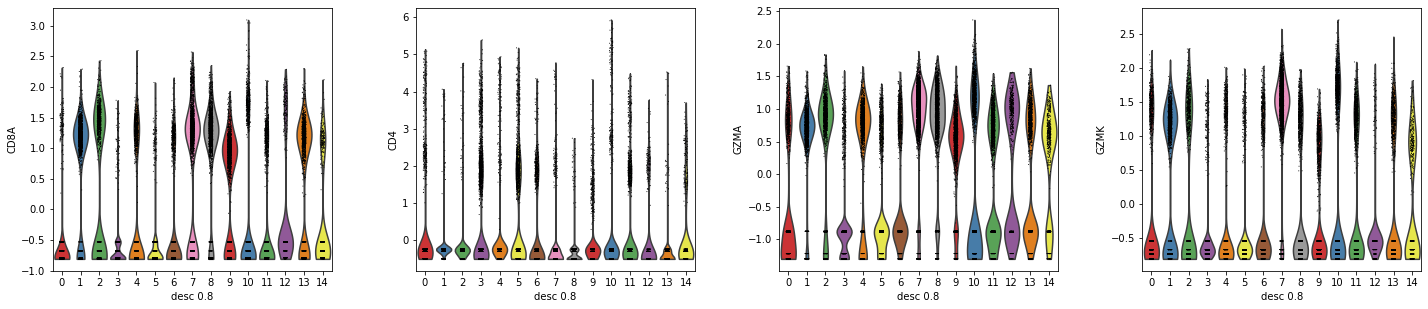

In [114]:
import warnings
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 5,5
sc.pl.violin(adata, ['CD8A', 'CD4','GZMA','GZMK'], groupby='desc_0.8')

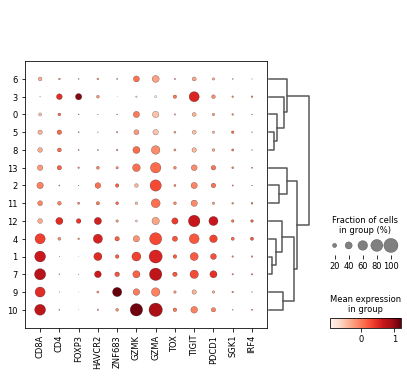

In [115]:
rcParams['figure.figsize'] = 10,10
sc.pl.dotplot(adata, ['CD8A','CD4','FOXP3','HAVCR2','ZNF683','GZMK','GZMA','TOX','TIGIT','PDCD1','SGK1','IRF4'], 'desc_0.6', dendrogram=True)

### Export Resolution 0.8

In [116]:
result = adata.uns['rank_genes_groups']

In [117]:
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:3]: result[key][group]
    for group in groups for key in ['names', 'pvals','logfoldchanges']}).to_csv("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res08_DEGS.csv",header=True,index=False)

In [118]:
adata.write("/home/spuccio/isilon/spuccio/SP025_NaClTcell/Analysis/Integrated/Integrated_res08.h5ad")